## OBJECT TRACKING IN IMAGE SEQUENCES USING KALMAN FILTER.

With all due credits to my colleague, Andrea Bricola. I took the videos that he used for his Kalman project as they were shot overhead.  I aim to track the billiard ball using Kalman Filter.
To get the coordinates of the ball on the table, I used several open-source libraries including openCV and ColorFinder from cvzone package. After getting the coordinates of the ball, I use the Kalman filter to predict its position using the coordinates. I went the extra mile by plotting the upper and lower bounds of the uncertainty in the predicted output. 

In [30]:
# load libraries
from cmath import sqrt
import cv2
import numpy as np
from Kalman import KF
from cvzone.ColorModule import ColorFinder
import cvzone
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation 
from IPython.display import Image,Video

### Initialising the video stream and tracking the ball.

In [14]:
# load video
# Initialize the stream
ball__list = ['ball3','ball4','ball5']     # There are 3 videos in the folder.
cap = cv2.VideoCapture(f'{ball__list[2]}.mov')

In [15]:
# get fps
fps = cap.get(cv2.CAP_PROP_FPS)  

print(f'Frames per Second: {int(fps)}')

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Duration
duration = (frame_count/fps)

print(f'Duration of the clip: {duration :.1f} Seconds')

Frames per Second: 30
Duration of the clip: 5.6 Seconds


In [16]:
# extract frames and track object
hsvVals = {'hmin': 0, 'smin': 197, 'vmin': 181, 'hmax': 179, 'smax': 255, 'vmax': 255}

In [17]:
# Create color finder object
myColorFinder = ColorFinder(False)

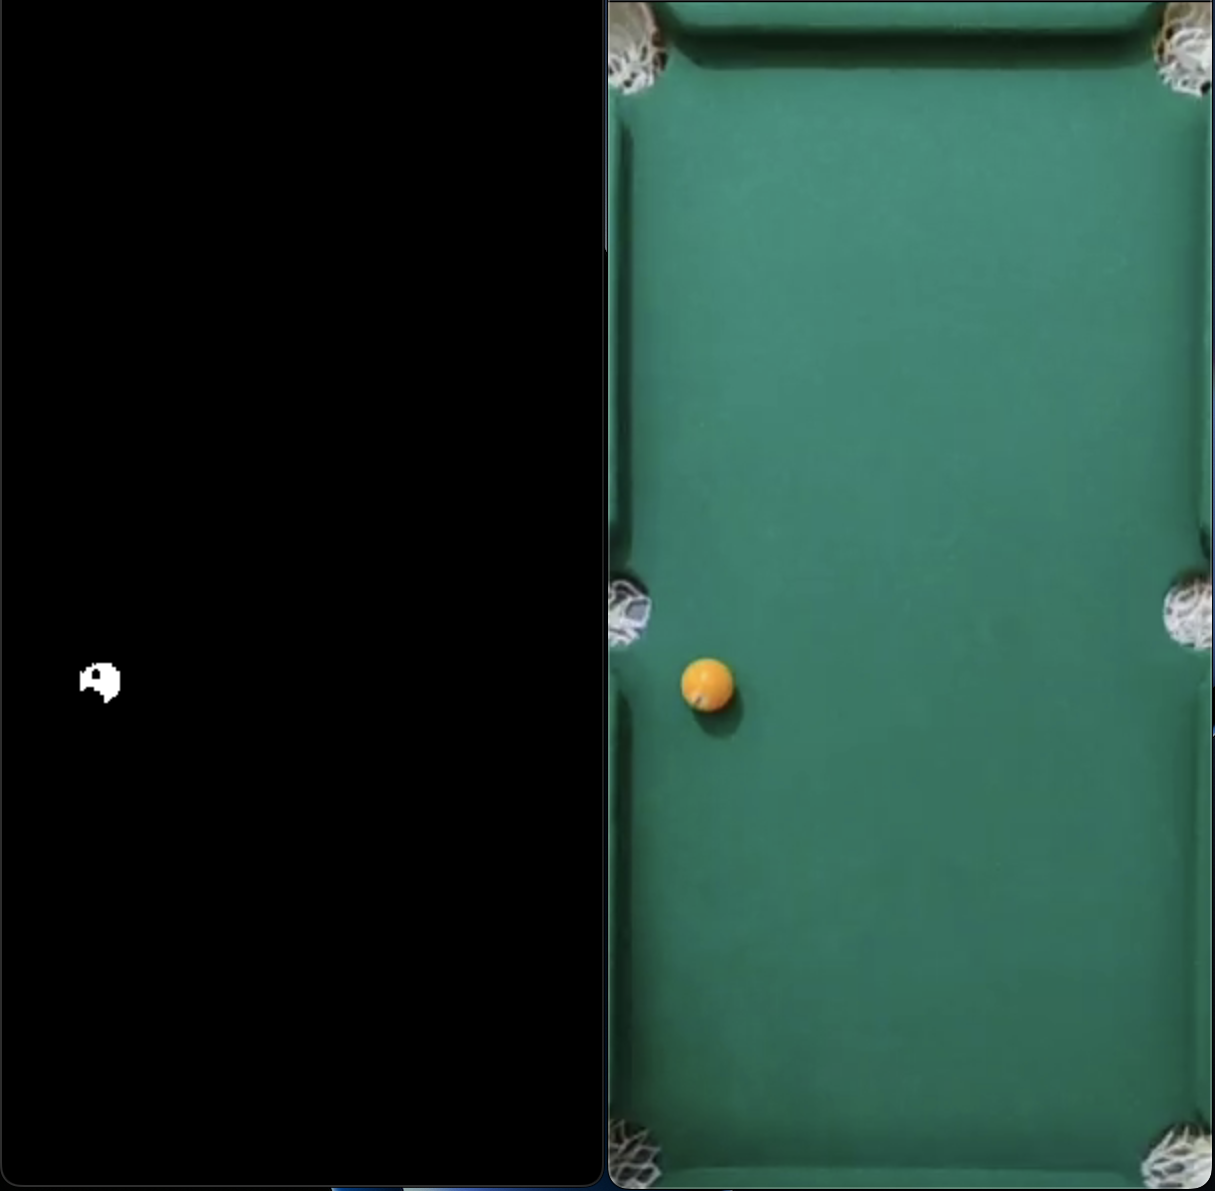

In [18]:
# a frame from the video and its mask
Image('img_mask.png')

## Tracking ball without Kalman Filter
The two graphs below show the position of ball in x and y direction with respect to time. 

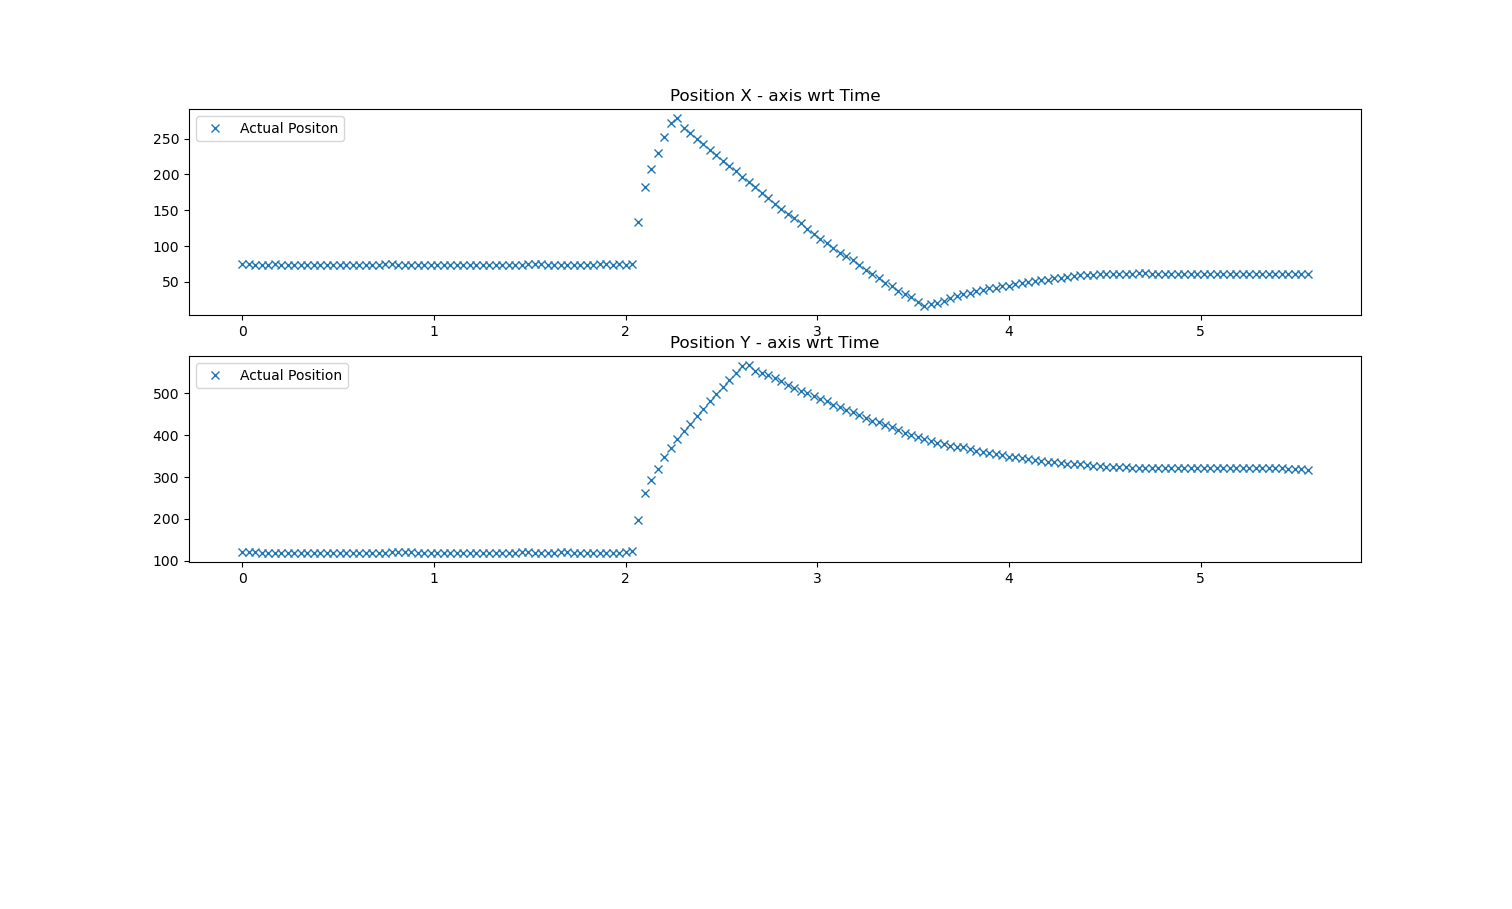

In [24]:
Image('actual_positions.png')

# Kalman Filter

Kalman filtering, also known as linear quadratic estimation (LQE), is an algorithm that uses a series of measurements observed over time, including statistical noise and other inaccuracies, and produces estimates of unknown variables that tend to be more accurate than those based on a single measurement alone, by estimating a joint probability distribution over the variables for each timeframe.

In our problem, we are tracking the movement of the ball on billiards table and it is modelled by the equations of motion. 
Since the motion is going to be in 2 dimensions, that is **x** and **y** , we will be having **position in x axis**, **position in y axis**, **velocity in x axis** and **velocity in y axis**.

We can't model accurately the object's movement, but we can have an acceptable approximation model of the movement. Assuming that the motion on the x-axis is uncorrelated to the motion on the y-axis. We can write the following discrete equations that describe the object's movements as shown below:

#### State Vector

$\underset{Nx1}{X_k} = [x_{k}, \dot{x}_k, y_{k}, \dot{y}_k]^T$

${x}$: Position in x-axis <br>
<strong>$\dot{x}$</strong> : Velocity in x-axis <br>
${y}$: Position in y-axis <br>
$\dot{y}$ : Velocity in y-axis




#### State Transition Matrix
$F=
\begin{pmatrix} 1&\Delta t&0&0 \\ 0&1&0&0 \\ 0&0&1&\Delta t\\ 0&0&0&1
\end{pmatrix}$

#### Control Input Matrix 

$G=
\begin{pmatrix} \Delta (t^2)/2&0 \\ \Delta t&0 \\ 0&\Delta (t^2)/2\\ 0&\Delta t
\end{pmatrix}$

#### Control Vector

$u_{k+1} =
\begin{pmatrix} a_x \\ a_y
\end{pmatrix}$


#### Covariance of Process Noise (Q)
The value of Q is unknown, and we will have to estimate it. Notice also how the off-diagonal elements of Q are zeros, this is due to our assumption that the motions on the x-axis and the y-axis, are uncorrelated.

$Q= E[qq^T]=\begin{pmatrix}
var(q_{x})&cov(q_{x}, q_{\dot{x}}) &0&0 \\
cov(q_{\dot{x}}, q_{x})&var(q_{\dot{x}})&0&0 \\
0&0&var(q_{y})&cov(q_{y}, q_{\dot{y}}) \\
0&0&cov(q_{\dot{y}}, q_{y}) &var(q_{\dot{y}}) \end{pmatrix}$ = 
$\begin{pmatrix} 
\Delta (t^4)/4& \Delta (t^3)/2 &0&0 \\ (\Delta t)^3/2& (\Delta t)^2 &0&0 \\ 0&0&\Delta (t^4)/2&\Delta (t^3)/2\\ 0&0&(\Delta t)^3/2 & (\Delta t)^2 
\end{pmatrix}$

#### Covariance of Measurement Noise (R)
We supposed that the measurement positions x and y are both independent, so we can ignore any interaction between them so that the covariance x and y is 0. We look at only the variance in the x and the variance in the y.

$R = E[rr^T] = \begin{pmatrix} cov(r_x,r_x) & cov(r_x,r_y) \\ cov(r_y,r_x) & cov(r_y,r_y)\end{pmatrix} = \begin{pmatrix} var(r_x) & 0 \\ 0 & var(r_y)\end{pmatrix}$

#### Measurement Model (z)
In deriving the observation model, we assume that we’re only measuring the position but not the velocity. Our object detection algorithm from openCV only gives us the coordinates of the tracked object, and not its velocity.

We’re now considering the particular case where the velocity will not be considered in the measurement process. So, we can write the measurement model as follows:


$\underset{M\times 1}{z_k} =
\underset{M\times N}{H_k} @ \underset{N\times 1}{X_k} + v_k =
\begin{pmatrix} 1&0&0&0 \\ 0&0&1&0 \end{pmatrix} @ \begin{pmatrix} x_k \\ \dot{x}_k \\ y_k \\ \dot{y}_k \end{pmatrix} +v_k$

We have the transformation matrix H as:

$ H =
\begin{pmatrix} 1&0&0&0 \\ 0&0&1&0 \end{pmatrix} $


## Kalman Filter Model


$X_{k+1} =$
$F @ X_{k} + G @ U_{k}=
\begin{pmatrix} 1&\Delta t&0&0 \\ 0&1&0&0 \\ 0&0&1&\Delta t\\ 0&0&0&1
\end{pmatrix}
\begin{pmatrix} x_k \\ \dot{x_k} \\ y_k \\ \dot{y_k} \end{pmatrix} + \begin{pmatrix} \Delta (t^2)/2&0 \\ \Delta t&0 \\ 0&\Delta (t^2)/2\\ 0&\Delta t
\end{pmatrix}\begin{pmatrix} a_x \\ a_y
\end{pmatrix}$



## Kalman Equations 
The Kalman filter can be written as a single equation; however, it is most often conceptualized as two distinct phases: **"Predict" and "Update"**. 
<p>The predict phase uses the state estimate from the previous timestep to produce an estimate of the state at the current timestep. This predicted state estimate is also known as the a priori state estimate because, although it is an estimate of the state at the current timestep, it does not include observation information from the current timestep. </p>
    <p>In the update phase, the innovation (the pre-fit residual), i.e. the difference between the current a priori prediction and the current observation information, is multiplied by the optimal Kalman gain and combined with the previous state estimate to refine the state estimate. This improved estimate based on the current observation is termed the a posteriori state estimate.</p>


### Predict Step
#### (Predicted (a priori) state estimate)
$X_{k+1} = F.X_{k} + G_{k}.U_{k} $  

#### (Predicted estimate covariance)
$P_{k+1} = F.P_{k}.F^T +Q_k $  


### Update Step

#### Innovation Residual 
$y_{k+1} = z_{k} - H.X_{k} $
#### Innovation Covariance 
$S_{k+1} = H.P_{k}.H^T + R $ 
#### Optimal Kalman Gain 
$K_{k+1} = P_{k}.H^T.{S_{k}}^-1$ 
#### Updated State Estimate

$X_{k+1} = X_{k} + K_{k}.y_k $

#### Updated Estimate Covariance
$P_{k+1} = (I - K_k.H)P_k $



## Code for kalman filter
Using the equations above, I wrote the following class for implementing kalman filter. In our hypothesis we assume acceleration to be the control input. 

In [26]:
import numpy as np

iX = 0                      # position in X
iXv = 1                     # Velocity in X
iY = 2                      # Position in Y
iYv = 3                     # velocity in Y

NUM_VARS = iYv + 1


class KF:
    """
    A class to track a signal using Kalman filter
    ...
    
    
    Init Parameters
    ----------
    acc_x_dir : float
        Acceleration in x-direction.
        
    acc_y_dir : float
        Acceleration in y-direction.
        
    std_acc : float
        Standard deviation of acceleration which affects the process noise covariance matrix. 
        
    x_std_meas : float
        Standard deviation of the measured values of x-axis position. 
        
    y_std_meas : float
         Standard deviation of the measured values of x-axis position. 
        
        
    Methods
    -------
    predict(dt:float)
        computes state estimate and covariance estimate.
    
    update(measured_x:float, measured_y : float)
        Updates the state and covariance matrix with the new measurements.
        
        
    """
    def __init__(self, acc_x_dir : float,
                       acc_y_dir : float,
                       std_acc : float,
                       x_std_meas : float,
                       y_std_meas : float,
                       ) -> None:

        self._x = np.zeros(NUM_VARS)

        self.u = np.array([[acc_x_dir],[acc_y_dir]])

        # Process Noise Magnitude
        self.std_acc = std_acc

    

        # mean of state Gaussian R.V
        self._x[iX]   = 0
        self._x[iXv]  = 0
        self._x[iY]   = 0
        self._x[iYv]  = 0
        
        # covariance of state GRV
        self._P = np.eye(NUM_VARS)

        self.R = np.array([[x_std_meas**2,0],
                           [0, y_std_meas**2]])
    
    def predict(self, dt: float) -> None:
        # x = F * x
        # P = F P Ft + G Gt a
        # F = np.eye(NUM_VARS)
        

        #  Process Noise Covariance 
        Q = np.array([
            [(dt**4)/4,  (dt**3)/2, 0 , 0],
            [(dt**3)/2, dt**2, 0, 0],
            [0,0,(dt**4)/4, (dt**3)/2],
            [0,0,(dt**3)/2,dt**2 ]
            ]) #* self.std_acc **2
        
        # state transition model 
        F = np.array([
                      [1, dt, 0, 0 ], 
                      [0,  1, 0, 0 ],
                      [0,  0, 1, dt],
                      [0,  0, 0, 1 ]
                      ])
        
       

        # control-input model 
        G = np.array([
            [0.5*dt**2, 0],
            [dt,        0],
            [0, 0.5*dt**2],
            [0,        dt]
        ])


        new_x = F.dot(self._x.reshape((4,1))) + G.dot(self.u)

        new_P = F.dot(self._P).dot(F.T) + Q

        self._x = new_x
        self._P = new_P

    def update(self,measured_x: float, measured_y: float):
        # y = z - Hx
        # S = H P Ht + R
        # K = P Ht S^-1
        # x = x + ky
        # P = (I -kH) * P

        # self._x = np.reshape(self._x,(4,1))

        H = np.array([[1,0,0,0],[0,0,1,0]]).reshape((2,4))

        # Measurements with noise
        z = np.array([measured_x,measured_y]).reshape((2,1)) 
        
        # Innovation Residual
        y = z - H.dot(self._x.reshape((4,1)))
        
        # Innovation Covariance 
        S = H.dot(self._P).dot(H.T) + self.R

        # Kalman Gain
        K = (self._P).dot(H.T).dot(np.linalg.inv(S))
        

        kdoty = K.dot(y)

        # Updated x (State)
        new_x = (self._x).reshape((4,1))+ kdoty

        # Updated Covariance
        new_P = (np.eye(4) - K.dot(H)).dot(self._P)

        self._P = new_P
        self._x = new_x
        

    @property
    def pos(self):
        return (self._x[0],self._x[2])

    @property
    def vel(self):
        return self._x[1]

    @property
    def cov(self) -> np.array:
        return self._P

    @property
    def mean(self) -> np.array:
        return self._x


## Basic unittest for sanity check.
I had implemented a test to check that the following code worked as expected. 

In [28]:
from unittest import TestCase
from Kalman import KF
import numpy as np


class TestKF(TestCase):
    def test_can_construct_x_v(self):
        x = 0.1
        v = 0.2
         
        kf = KF(acc_x_dir=0.1,acc_y_dir=0.2,std_acc=0.5 ,x_std_meas=0.1,y_std_meas=0.1)
        # self.assertAlmostEqual(kf.pos,(0.1,0.2))

    def test_can_predict(self):
        x = 0.1
        v = 0.2
         
        kf = KF(acc_x_dir=0.1,acc_y_dir=0.2,std_acc=0.5 ,x_std_meas=0.1,y_std_meas=0.1)
        kf.predict(dt=0.1)

    def test_shape_of_x_and_P_are_correct(self):
        x = 0.1
        v = 2.4
         
        kf = KF(acc_x_dir=0.1,acc_y_dir=0.2,std_acc=0.5 ,x_std_meas=0.1,y_std_meas=0.1)
        kf.predict(dt=0.1)

        self.assertEqual(kf.cov.shape,(4,4))
        self.assertEqual(kf.mean.shape,(4,1))

    def test_predict_increases_uncertainity(self):
        x = 0.1
        v = 0.2
        kf = KF(acc_x_dir=0.1,acc_y_dir=0.2,std_acc=0.5 ,x_std_meas=0.1,y_std_meas=0.1)

        for i in range(10):
            det_before = np.linalg.det(kf.cov)
            kf.predict(dt=0.1)
            det_after = np.linalg.det(kf.cov)
            self.assertGreater(det_after,det_before)

    def test_update_function_works(self):
        x = 0.1
        v = 0.2
        kf = KF(acc_x_dir=0.1,acc_y_dir=0.2,std_acc=0.5 ,x_std_meas=0.1,y_std_meas=0.1)

        kf.update(measured_x=23,measured_y=25)

    def test_update_decreases_uncertainity(self):
        kf = KF(acc_x_dir=0.1,acc_y_dir=0.2,std_acc=0.5 ,x_std_meas=0.1,y_std_meas=0.1)
        for i in range(10):
            det_before = np.linalg.det(kf.cov)
            kf.update(measured_x=23+i,measured_y=25)
            det_after = np.linalg.det(kf.cov)
            self.assertLess(det_after,det_before)


# Results

I ran the code on two different videos and with different acceleration and standard deviations in measurements. 
Since the quality of the video was not very good, and the tracking algorithm was loosing tracking at some points, there were parts where the filter would lose tracking. 

In the plots below, there are 4 lines in the position plot. Dashed blue and dashed orange are 95% confidence (2-sigma interval) interval computed by standard deviation of covariance matrix. 


### VIDEO ONE
#### BALL3.MOV
- acc_x_dir   = 0.1
- acc_y_dir   = 0.1
- std_acc     = 2.0 
- x_std_meas  = 2.0
- y_std_meas  = 2.0

As we can see in the plot below, the filter started with some random value and as soon as some new values started coming in, it tracked the signal and started converging to the actual values. It was tracking fine till 1.5 seconds which was the point in which the ball hits the cushion of billiard table and changes direction. At that moment, the tracking is lost for a few seconds but again as there are readings coming in, Kalman filter tracking the signal and tried to keep it within the 95% confidence interval bounds. 

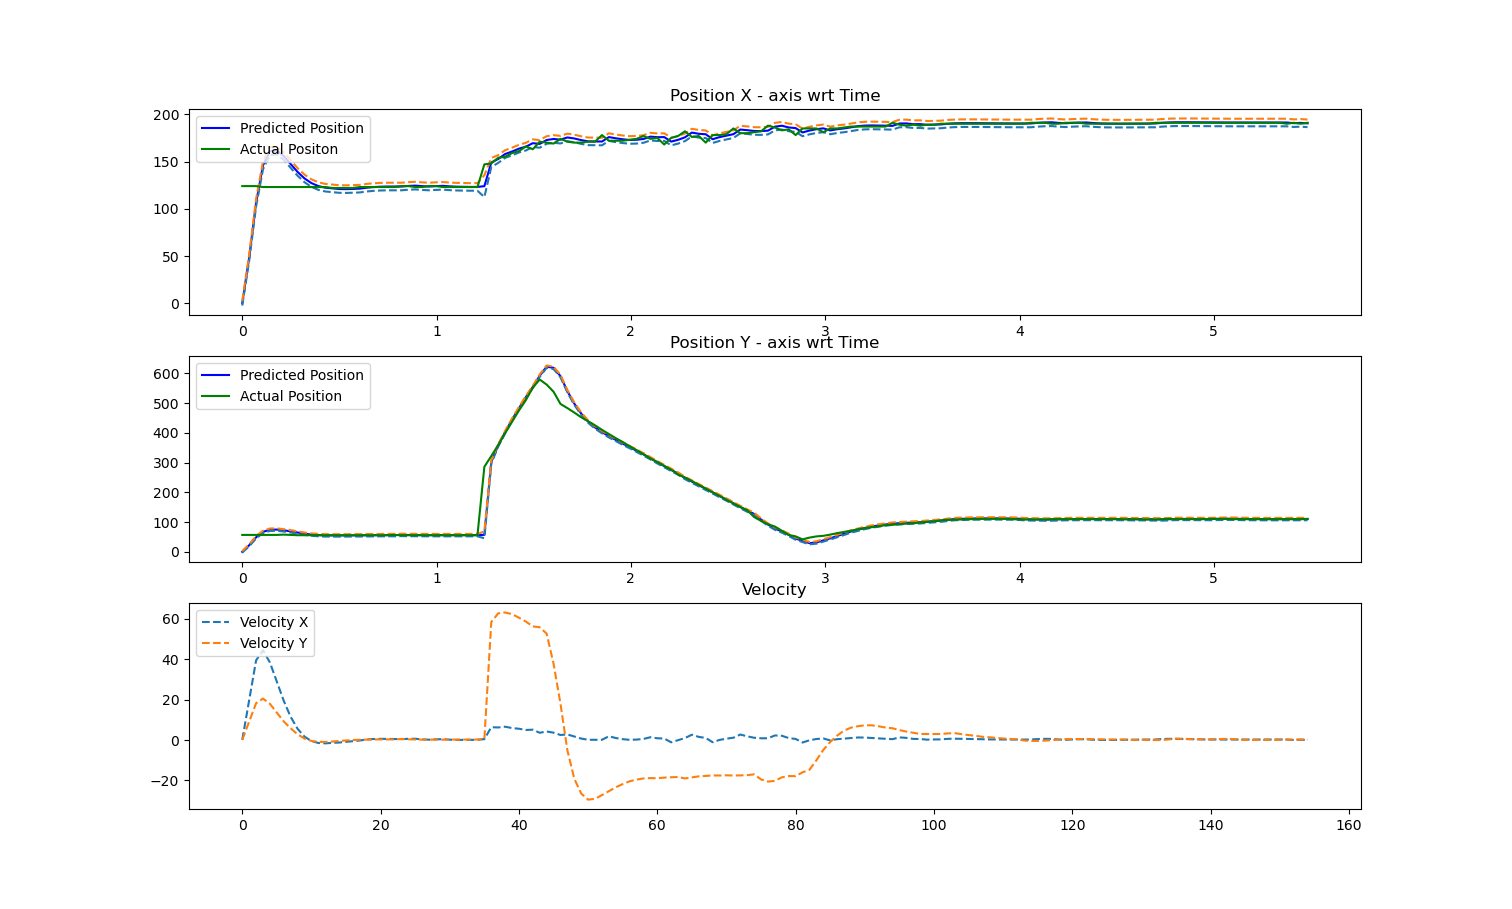

In [29]:
Image('ball1.png')

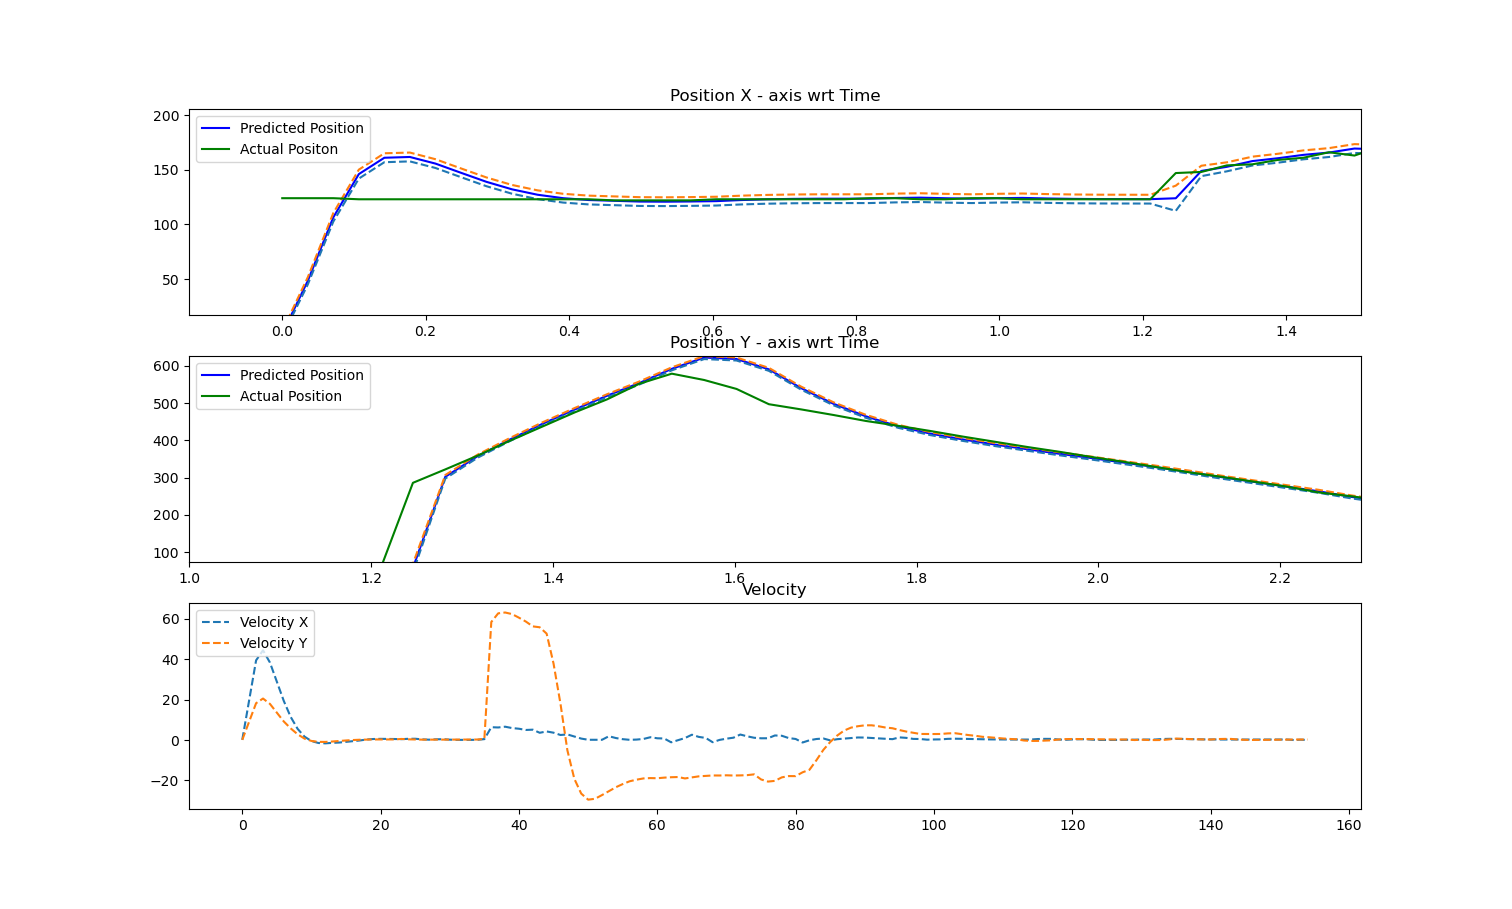

In [33]:
Image('zoomed1.png')

In [31]:
Video('v1.avi')

### VIDEO TWO
#### BALL4.MOV
- acc_x_dir   = 0.1
- acc_y_dir   = 0.1
- std_acc     = 2.0 
- x_std_meas  = 2.0
- y_std_meas  = 2.0

As we can see in the plot below, the filter started with some random value and as soon as some new values started coming in, it tracked the signal and started converging to the actual values. It was tracking fine till 1.5 seconds which was the point in which the ball hits the cushion of billiard table and changes direction. At that moment, the tracking is lost for a few seconds but again as there are readings coming in, Kalman filter tracking the signal and tried to keep it within the 95% confidence interval bounds. 

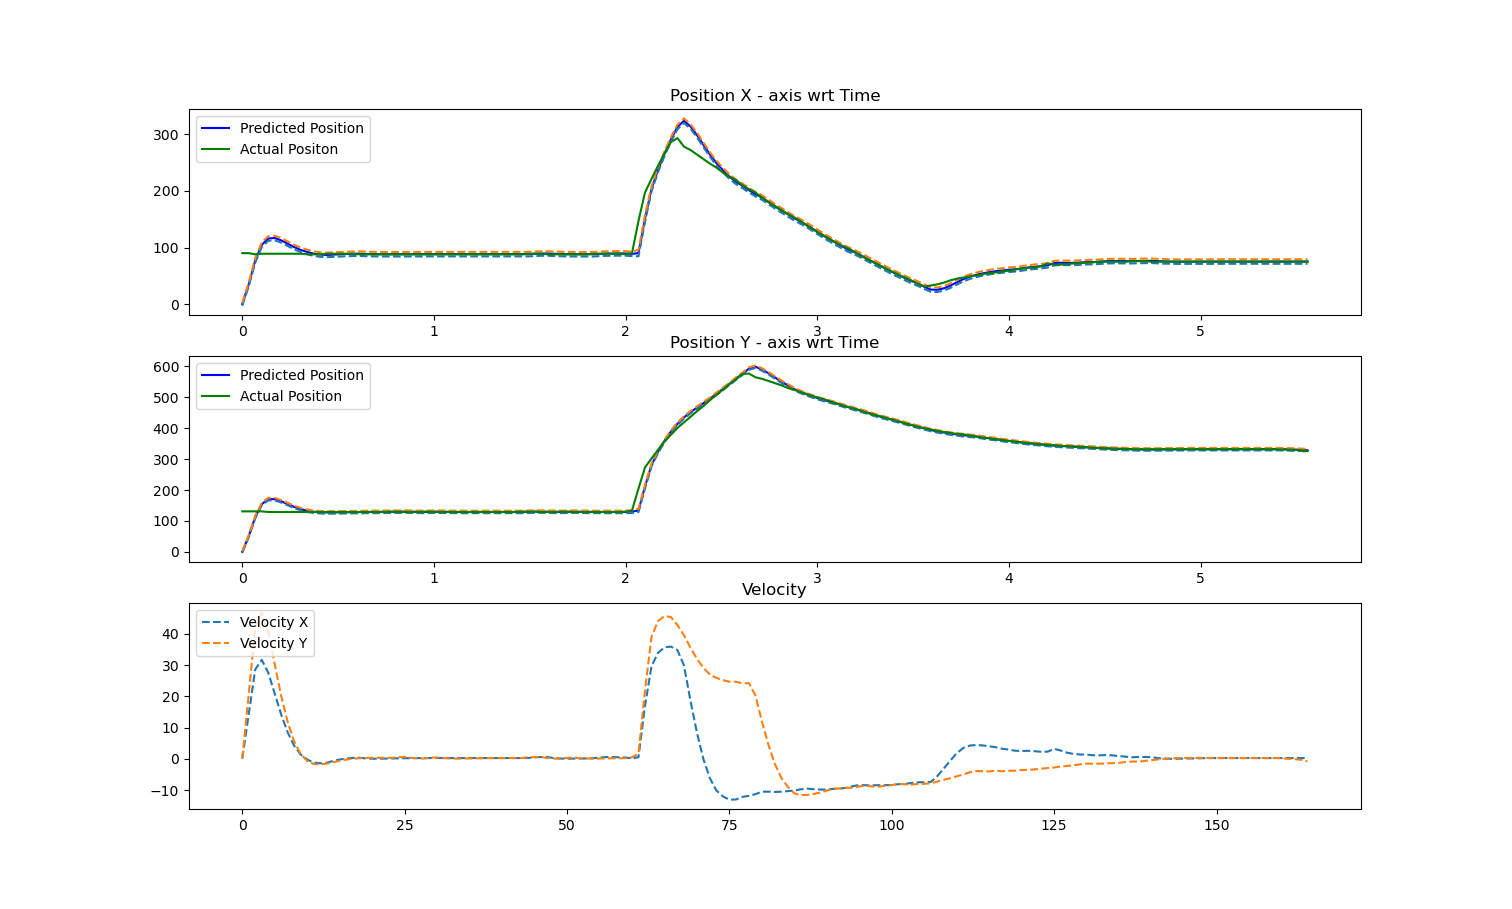

In [34]:
Image('figure_2.png')

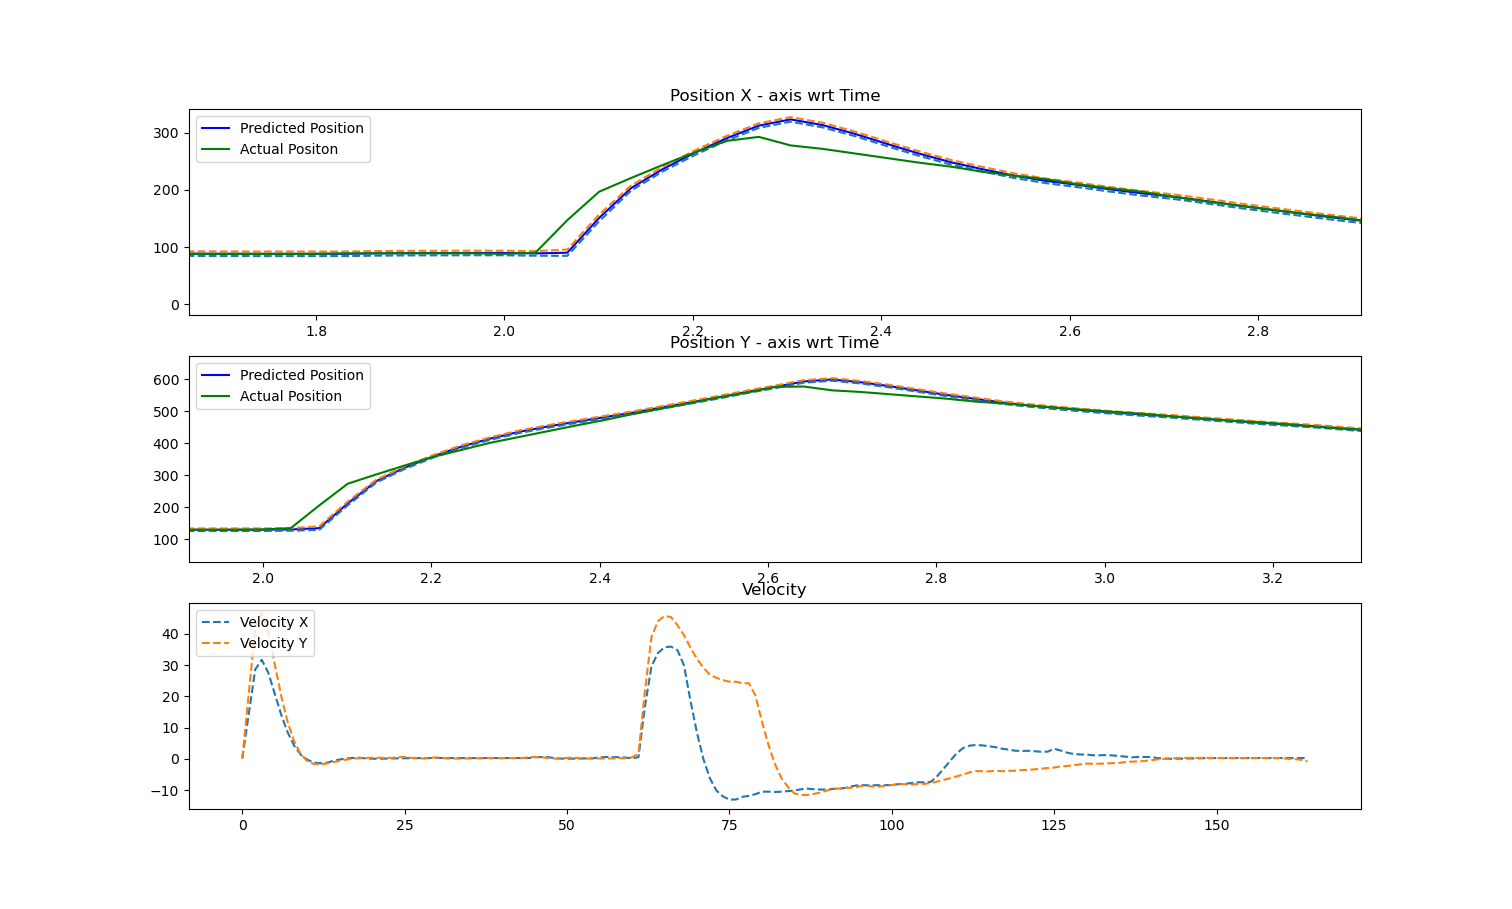

In [35]:
Image('zoomed_2.png')

### Playing with the parameters.
After playing a bit with the parameters such as stand deviation of acceleration and noise in the measurements. It turned out to perform a little better than the previous one at the points where it lost tracking. 

kf = KF(acc_x_dir=0.1,acc_y_dir=0.1,std_acc=2 ,x_std_meas=1,y_std_meas=1)


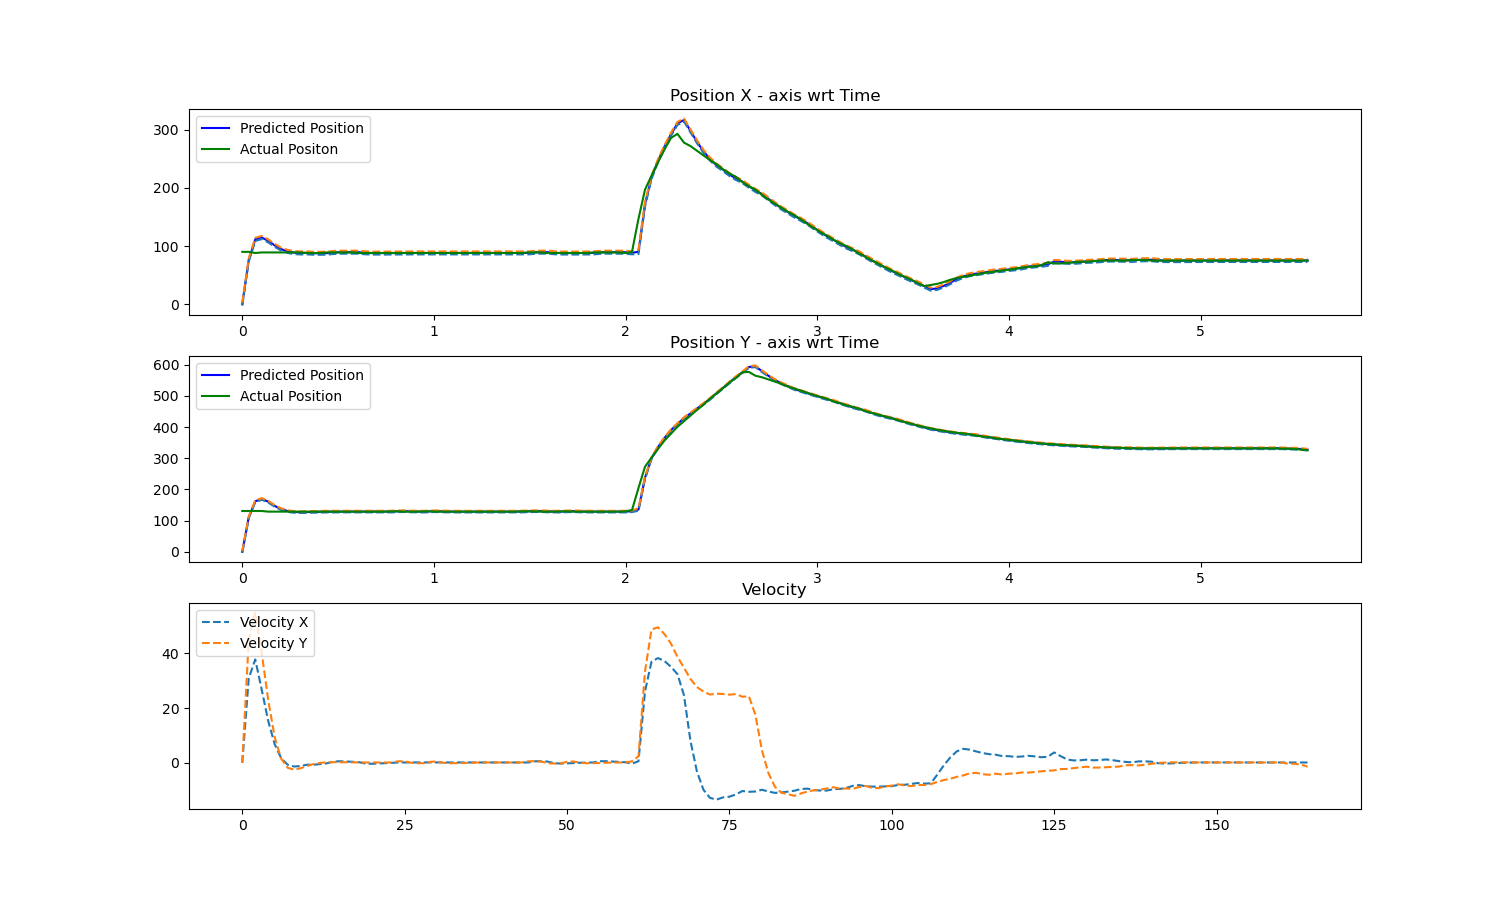

In [36]:
#

Image('figure_3.png')

In [37]:
Video('v2.avi')